This code is referenced from <br>
https://github.com/TannerGilbert/Object-Detection-and-Image-Segmentation-with-Detectron2

In [1]:
cd detectron2

/home/z890/Documents/ml_sample/detection/d2_FasterRCNN/detectron2


/home/z890/.conda/envs/d2_FasterRCNN/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import torch
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Run a pre-trained detectron2 model on image

We first download an image from the COCO dataset:

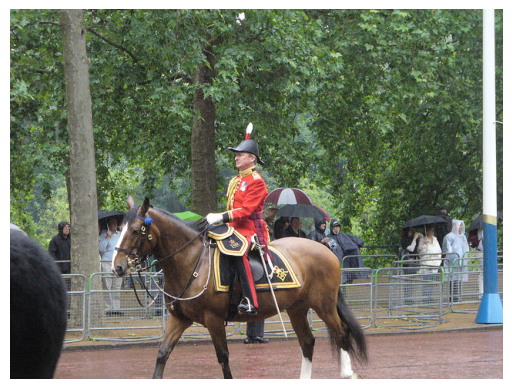

In [3]:
!wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg
import cv2
import matplotlib.pyplot as plt

# Read the image
im = cv2.imread("input.jpg")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct colors

# Display the image using Matplotlib
plt.imshow(im)
plt.axis("off")  # Hide axes
plt.show()

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

In [4]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

[06/02 11:31:09 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x/139173657/model_final_68b088.pkl ...


/home/z890/.conda/envs/d2_FasterRCNN/lib/python3.10/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


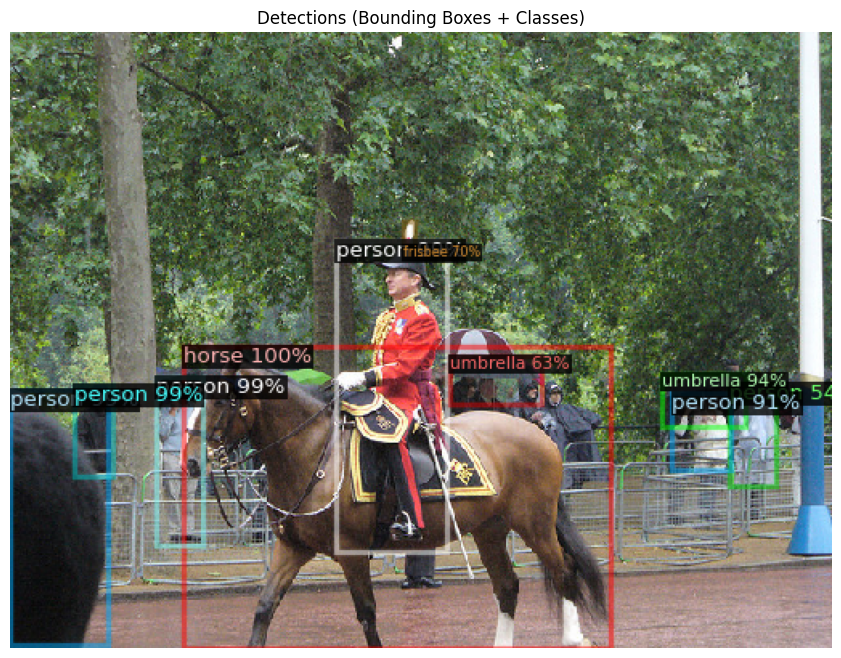

In [5]:
# see the difference of detection and instance segmentation
# detection return boxes framing the objects, while instance segmentation return maskes covering the objects
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import matplotlib.pyplot as plt

# Load metadata for COCO
coco_metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])

# Initialize Visualizer
v1 = Visualizer(im[:, :, ::-1], metadata=coco_metadata, scale=0.8)

# --- 1. Plot Detections (Bounding Boxes + Classes) ---
detections = outputs["instances"].to("cpu")
vis_detections = v1.draw_instance_predictions(detections)

plt.figure(figsize=(12, 8))
plt.imshow(vis_detections.get_image()[:, :, ::-1])
plt.title("Detections (Bounding Boxes + Classes)")
plt.axis("off")
plt.show()

# Run a pre-trained detectron2 model on video

Here we demo how to inference a pretrained model on a video

Download model weights from <br>
https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md <br>
Search the keywords "Object Detection" to get suitable model

The code will be <br>
%run demo/demo.py --config-file "location of model yaml" --video-input "an mp4" --confidence-threshold "threshold" --output videooutput.mp4 --opts MODEL.WEIGHTS "downloaded pretrained weights" <br>
run frame-by-frame inference demo on this video (so it takes minutes) <br>
you must use --output to save file <br>

In [ ]:
%run demo/demo.py --config-file configs/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml --video-input ../vecteezy_aerial-view-white-car-travels-in-beautiful_3582352.mp4 --confidence-threshold 0.6 --output ../videooutput.mp4 \
  --opts MODEL.WEIGHTS ../model_final_68b088.pkl

[06/02 11:31:37 detectron2]: Arguments: Namespace(config_file='configs/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml', webcam=False, video_input='../vecteezy_aerial-view-white-car-travels-in-beautiful_3582352.mp4', input=None, output='videooutput.mp4', confidence_threshold=0.6, opts=['MODEL.WEIGHTS', '../model_final_68b088.pkl'])
[06/02 11:31:38 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ../model_final_68b088.pkl ...
[06/02 11:31:38 fvcore.common.checkpoint]: [Checkpointer] Loading from ../model_final_68b088.pkl ...
[06/02 11:31:38 fvcore.common.checkpoint]: Reading a file from 'Detectron2 Model Zoo'


[ERROR:0@37.481] global cap_ffmpeg_impl.hpp:3203 open Could not find encoder for codec_id=27, error: Encoder not found
[ERROR:0@37.481] global cap_ffmpeg_impl.hpp:3281 open VIDEOIO/FFMPEG: Failed to initialize VideoWriter
[ WARN:0@37.481] global cap.cpp:779 open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.11.0) /io/opencv/modules/videoio/src/cap_images.cpp:415: error: (-215:Assertion failed) !filename_pattern.empty() in function 'CvVideoWriter_Images'


100%|██████████| 328/328 [01:28<00:00,  3.71it/s]


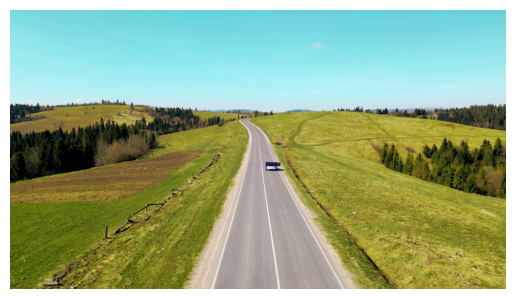

In [10]:
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

video_path = '../videooutput.mp4'  # or full path
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error opening video file")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert BGR (OpenCV format) to RGB (Matplotlib format)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Display the frame using matplotlib
    plt.imshow(frame_rgb)
    plt.axis('off')
    clear_output(wait=True)  # Clear the previous frame
    plt.show()

cap.release()
